Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [3]:
data = pd.read_csv('../data/num_file/hrs_01/p040.csv')

In [4]:
print(data)

                 datetime  count
0     2022-04-21 01:00:00   1033
1     2022-04-21 02:00:00     65
2     2022-04-21 03:00:00      0
3     2022-04-21 04:00:00      0
4     2022-04-21 05:00:00      0
...                   ...    ...
3246  2022-09-03 07:00:00   9741
3247  2022-09-03 08:00:00  19613
3248  2022-09-03 09:00:00  22055
3249  2022-09-03 10:00:00  14644
3250  2022-09-03 11:00:00  12751

[3251 rows x 2 columns]


If there is no people, use NaN.

In [5]:
data.loc[data['count']==0, 'count'] = np.NaN

In [6]:
print(data)

                 datetime    count
0     2022-04-21 01:00:00   1033.0
1     2022-04-21 02:00:00     65.0
2     2022-04-21 03:00:00      NaN
3     2022-04-21 04:00:00      NaN
4     2022-04-21 05:00:00      NaN
...                   ...      ...
3246  2022-09-03 07:00:00   9741.0
3247  2022-09-03 08:00:00  19613.0
3248  2022-09-03 09:00:00  22055.0
3249  2022-09-03 10:00:00  14644.0
3250  2022-09-03 11:00:00  12751.0

[3251 rows x 2 columns]


<Axes: >

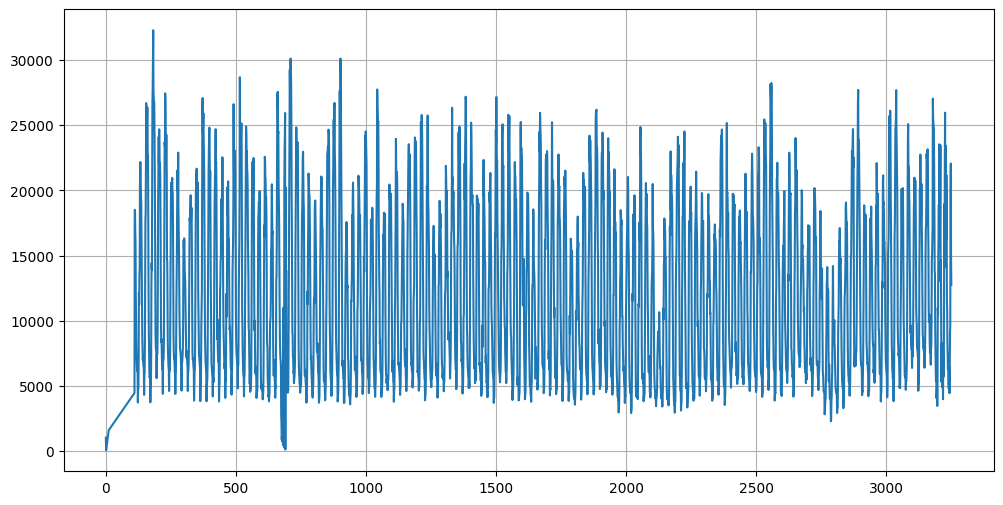

In [7]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

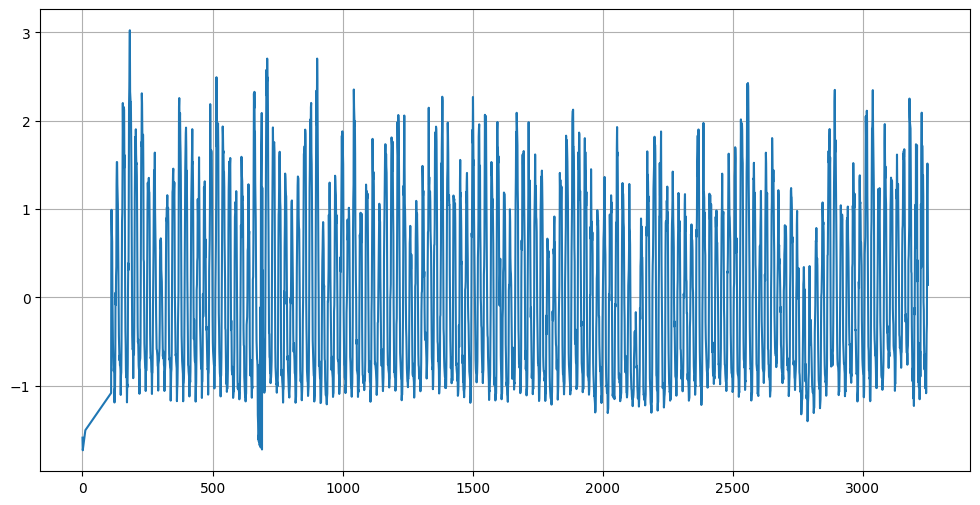

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [9]:
print(data)

                 datetime     count
0     2022-04-21 01:00:00 -1.588140
1     2022-04-21 02:00:00 -1.730996
2     2022-04-21 03:00:00 -1.708284
3     2022-04-21 04:00:00 -1.685572
4     2022-04-21 05:00:00 -1.662859
...                   ...       ...
3246  2022-09-03 07:00:00 -0.303021
3247  2022-09-03 08:00:00  1.153879
3248  2022-09-03 09:00:00  1.514267
3249  2022-09-03 10:00:00  0.420559
3250  2022-09-03 11:00:00  0.141192

[3251 rows x 2 columns]


In [10]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [11]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [12]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [15]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

<KerasTensor shape=(None, 12, 32), dtype=float32, sparse=False, name=keras_tensor_2>
<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_3>
<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_4>


2024-05-03 17:51:33.770514: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-03 17:51:33.770538: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-03 17:51:33.770543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-03 17:51:33.770562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-03 17:51:33.770573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [17]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

<KerasTensor shape=(None, 12, 32), dtype=float32, sparse=False, name=keras_tensor_7>


In [18]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

<KerasTensor shape=(None, 12, 32), dtype=float32, sparse=False, name=keras_tensor_8>


In [19]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [20]:
attention = Activation('relu')(attention)

In [21]:
print(attention)

<KerasTensor shape=(None, 12, 12), dtype=float32, sparse=False, name=keras_tensor_10>


In [22]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

<KerasTensor shape=(None, 12, 32), dtype=float32, sparse=False, name=keras_tensor_12>


In [23]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

<KerasTensor shape=(None, 12, 64), dtype=float32, sparse=False, name=keras_tensor_13>


In [24]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

<KerasTensor shape=(None, 12, 1), dtype=float32, sparse=False, name=keras_tensor_14>


In [25]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 12, 32),  │      4,352 │ input_layer[0][0] │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ lstm[0][1]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 12, 32)    │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm[0][2]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 12, 32)    │      8,320 │ repeat_vector[0]… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 12, 12)    │          0 │ lstm_1[0][0],     │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 12, 12)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 12, 32)    │          0 │ activation[0][0], │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 32)    │        128 │ dot_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 1)     │         65 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,121 (51.25 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 192 (768.00 B)

In [26]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [27]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100


2024-05-03 17:51:34.751143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 1.3401 - mae: 0.7193 - val_loss: 0.4199 - val_mae: 0.5436
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1952 - mae: 0.3269 - val_loss: 0.5504 - val_mae: 0.6381
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1196 - mae: 0.2502 - val_loss: 0.5807 - val_mae: 0.6592
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0969 - mae: 0.2292 - val_loss: 0.4699 - val_mae: 0.5718
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1143 - mae: 0.2536 - val_loss: 0.4347 - val_mae: 0.5434
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0882 - mae: 0.2169 - val_loss: 0.3988 - val_mae: 0.5038
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0697 - mae: 0.1864 - val_loss: 0.4313 - val_mae: 0.5405
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0782 - mae: 0.2026 - val_loss: 0.3139 - val_mae: 0.4523
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0757 -

In [28]:
# model.save('./params/p040_seq2seq_at.keras')

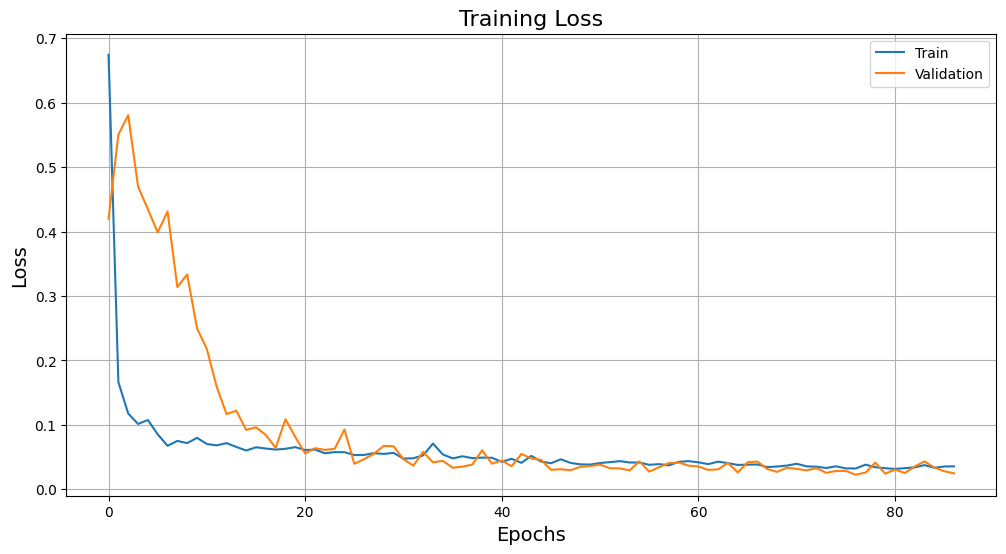

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [30]:
predict_test = model.predict(encode_input_data_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [31]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

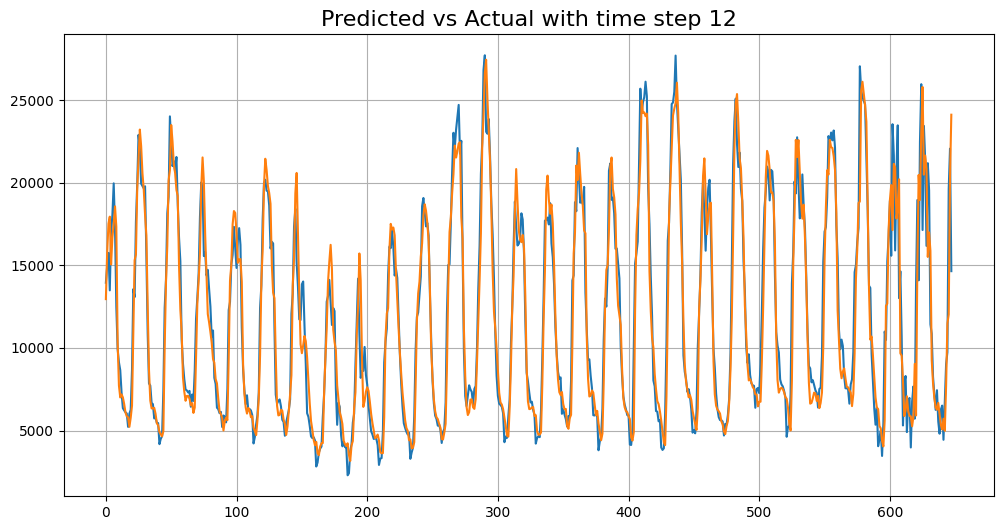

In [32]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'Predicted vs Actual with time step {time_step}')
plt.show()

In [33]:
print(predict_test_data)

[[12952.183 ]
 [15776.628 ]
 [17518.635 ]
 [17941.578 ]
 [15049.564 ]
 [16681.57  ]
 [17485.162 ]
 [18564.01  ]
 [17337.592 ]
 [10336.717 ]
 [ 7719.0283]
 [ 7002.63  ]
 [ 7188.7534]
 [ 7012.8223]
 [ 6609.6504]
 [ 6096.364 ]
 [ 5858.5596]
 [ 5810.321 ]
 [ 5225.5566]
 [ 5769.5786]
 [ 6507.4634]
 [10993.38  ]
 [15307.073 ]
 [15636.322 ]
 [19658.268 ]
 [21460.648 ]
 [23209.418 ]
 [22204.814 ]
 [20565.451 ]
 [19563.023 ]
 [18042.414 ]
 [16808.584 ]
 [12491.405 ]
 [ 8653.327 ]
 [ 6812.2974]
 [ 6341.504 ]
 [ 6342.0366]
 [ 6377.1   ]
 [ 6025.223 ]
 [ 5440.1562]
 [ 5319.3315]
 [ 4909.142 ]
 [ 4770.8687]
 [ 4652.5615]
 [ 4955.0176]
 [10031.034 ]
 [13965.119 ]
 [16179.421 ]
 [20112.355 ]
 [20761.932 ]
 [23483.373 ]
 [22493.092 ]
 [21124.215 ]
 [20578.6   ]
 [19556.545 ]
 [19199.166 ]
 [14954.605 ]
 [12310.783 ]
 [10973.662 ]
 [ 8224.09  ]
 [ 7359.2754]
 [ 6801.2573]
 [ 7097.2773]
 [ 7095.752 ]
 [ 6927.3438]
 [ 6525.5894]
 [ 6655.395 ]
 [ 6067.4697]
 [ 6390.196 ]
 [ 9387.13  ]
 [12705.343 ]
 [1408

In [34]:
print(decode_output_test_data)

[[13944.]
 [14966.]
 [15750.]
 [13482.]
 [16959.]
 [18055.]
 [19955.]
 [17252.]
 [12476.]
 [ 9933.]
 [ 9129.]
 [ 8654.]
 [ 7305.]
 [ 6357.]
 [ 6222.]
 [ 6108.]
 [ 6036.]
 [ 5224.]
 [ 6020.]
 [ 6260.]
 [ 8659.]
 [13555.]
 [13072.]
 [17624.]
 [19917.]
 [22889.]
 [22064.]
 [19935.]
 [19792.]
 [19655.]
 [19780.]
 [15581.]
 [10866.]
 [ 7849.]
 [ 7721.]
 [ 6671.]
 [ 6599.]
 [ 5733.]
 [ 5798.]
 [ 5470.]
 [ 5451.]
 [ 4178.]
 [ 4497.]
 [ 4660.]
 [ 7428.]
 [12414.]
 [14162.]
 [18146.]
 [19131.]
 [24008.]
 [22511.]
 [21002.]
 [21305.]
 [20646.]
 [21552.]
 [18702.]
 [16659.]
 [15251.]
 [10539.]
 [ 9051.]
 [ 8118.]
 [ 7483.]
 [ 7426.]
 [ 7304.]
 [ 7400.]
 [ 6442.]
 [ 7179.]
 [ 6793.]
 [ 8619.]
 [11747.]
 [13050.]
 [14511.]
 [17926.]
 [20011.]
 [19568.]
 [15556.]
 [15796.]
 [14385.]
 [14723.]
 [13566.]
 [12512.]
 [10660.]
 [11054.]
 [ 8193.]
 [ 7822.]
 [ 6384.]
 [ 6296.]
 [ 6052.]
 [ 6130.]
 [ 5216.]
 [ 5914.]
 [ 5808.]
 [ 5497.]
 [ 7531.]
 [12297.]
 [12772.]
 [15064.]
 [15622.]
 [17326.]
 [16024.]


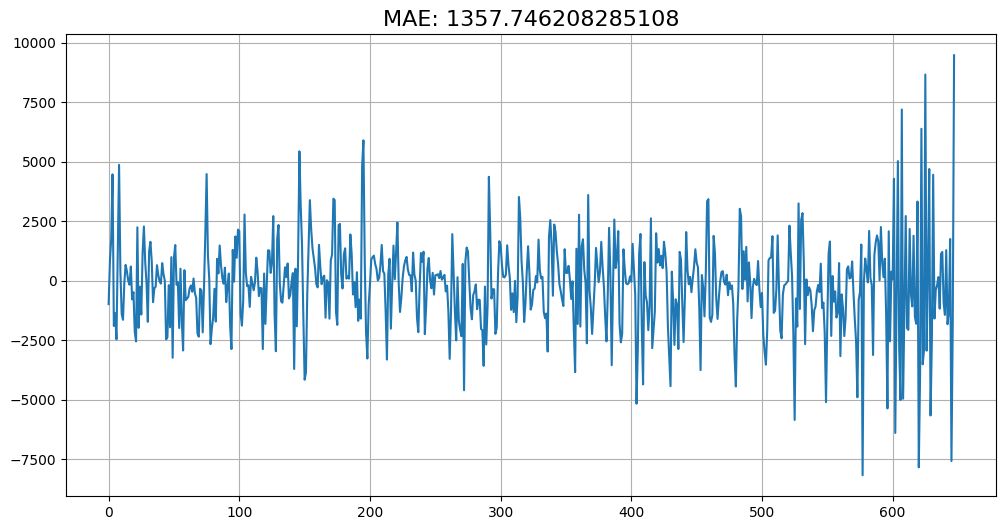

In [35]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

1357.746208285108
